## Section 4: Bayesian Regression

Previously, we addressed the question: "is my chat response time effected by who I'm talking to?". We have estimated model parameters for each individual I've had conversations with. But sometimes we want to understand the effect of more factors such as "day of week," "time of day," etc. We can use GLM (generalized linear models) to better understand the effects of these factors.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import seaborn.apionly as sns
import statsmodels.api as sm
import theano.tensor as tt

from sklearn import preprocessing

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

messages = pd.read_csv('data/hangout_chat_data.csv')

### Linear regression reminder

When we have a response $y$ that is continuous from $-\infty$ to $\infty$, we can consider using a linear regression represented by: 

$$y \sim \mathcal{N}(\mu, \sigma)$$
$$\mu = \beta_0 + \beta_1 X_1 ... \beta_n X_n$$

We read this as: our response is normally distributed around $\mu$ with a standard deviation of $\sigma$. The value of $\mu$ is described by a linear function of explanatory variables $X \beta$ with a baseline intercept $\beta_0$.

### Link functions

In the event you're not modeling a continuous response variable from $-\infty$ to $\infty$, you may need to use a link function to transform your response range. For a Poisson distribution, the canonical link function used is the log link. This can be formally described as:

$$y \sim Poi(\mu)$$
$$log(\mu) = \beta_0 + \beta_1 X_1 ... \beta_n X_n$$
$$\mu = e^{(\beta_0 + \beta_1 X_1 ... \beta_n X_n)}$$

This is considered to be a fixed effects model. The $\beta$ coefficients are estimated across the entire population as opposed to estimating separate parameters for each person (like in the pooled and partially pooled model in Section 3).

### Fixed effects Poisson regression

To construct a Poisson regression in PyMC3, we need to apply the log link function to $\mu$.  The underlying data model in PyMC3 uses theano and hence we need to use the theano tensor method `theano.tensor.exp()` as shown below.

In [2]:
X = messages[['is_weekend','day_of_week','message_length','num_participants']].values
_, num_X = X.shape

with pm.Model() as model:       
    intercept = pm.Normal('intercept', mu=0, sd=100)
    beta_message_length = pm.Normal('beta_message_length', mu=0, sd=100)
    beta_is_weekend = pm.Normal('beta_is_weekend', mu=0, sd=100)
    beta_num_participants = pm.Normal('beta_num_participants', mu=0, sd=100)
    
    mu = tt.exp(intercept 
                + beta_message_length*messages.message_length 
                + beta_is_weekend*messages.is_weekend
                + beta_num_participants*messages.num_participants)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

100%|██████████| 200000/200000 [01:45<00:00, 1888.25it/s]


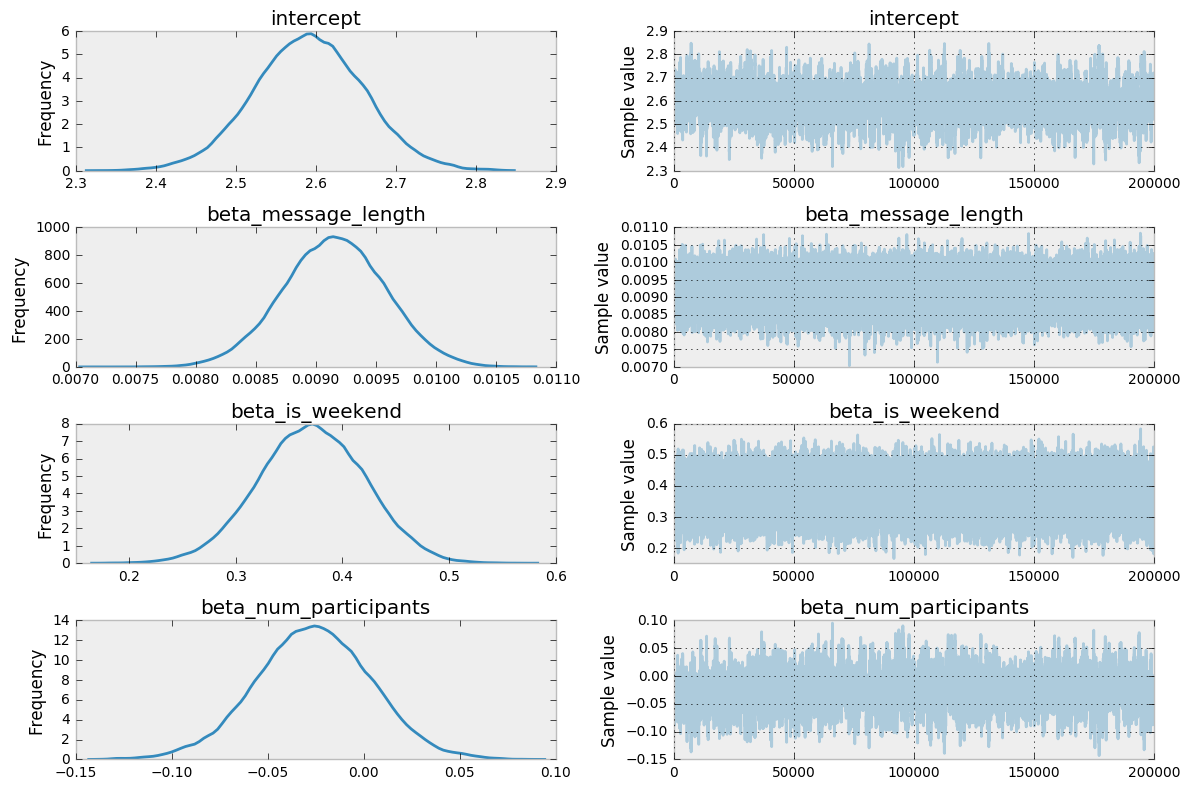

In [3]:
_ = pm.traceplot(trace)

As you can see from the above results, the baseline intercept $\beta_0$ has an estimated value of between 2.4 and 2.8. So what does this mean?

Unfortunately, interpreting the parameters of a Poisson regression is more involved than a simple linear regression (y = $\beta$ x). In this linear regression, we could say for every unit increase in x, $\hat{y}$ increases by $\beta$. However, in the Poisson regression we need to consider the link function. The [following cross validated post](http://stats.stackexchange.com/questions/128926/how-to-interpret-parameter-estimates-in-poisson-glm-results) explains in great detail how we arrive at the below formulation.

> For a Poisson model, given a unit change in $x$, the fitted $\hat y$ changes by $\hat y \left( e^\beta - 1 \right)$

The main takeaway from this is that the effect of changing x depends on the current value of y. Unlike the simple linear regression, a unit change in x does not cause a consistent change in y.

###  Marginal and pairwise density plots

The below plot shows the marginal densities (across the diagonal) and the pairwise densities (lower and upper panes). This plot is very useful for understanding how covariates interact with one another. In the above example, we can see that as the number of participants increases, the baseline intercept decreases. 

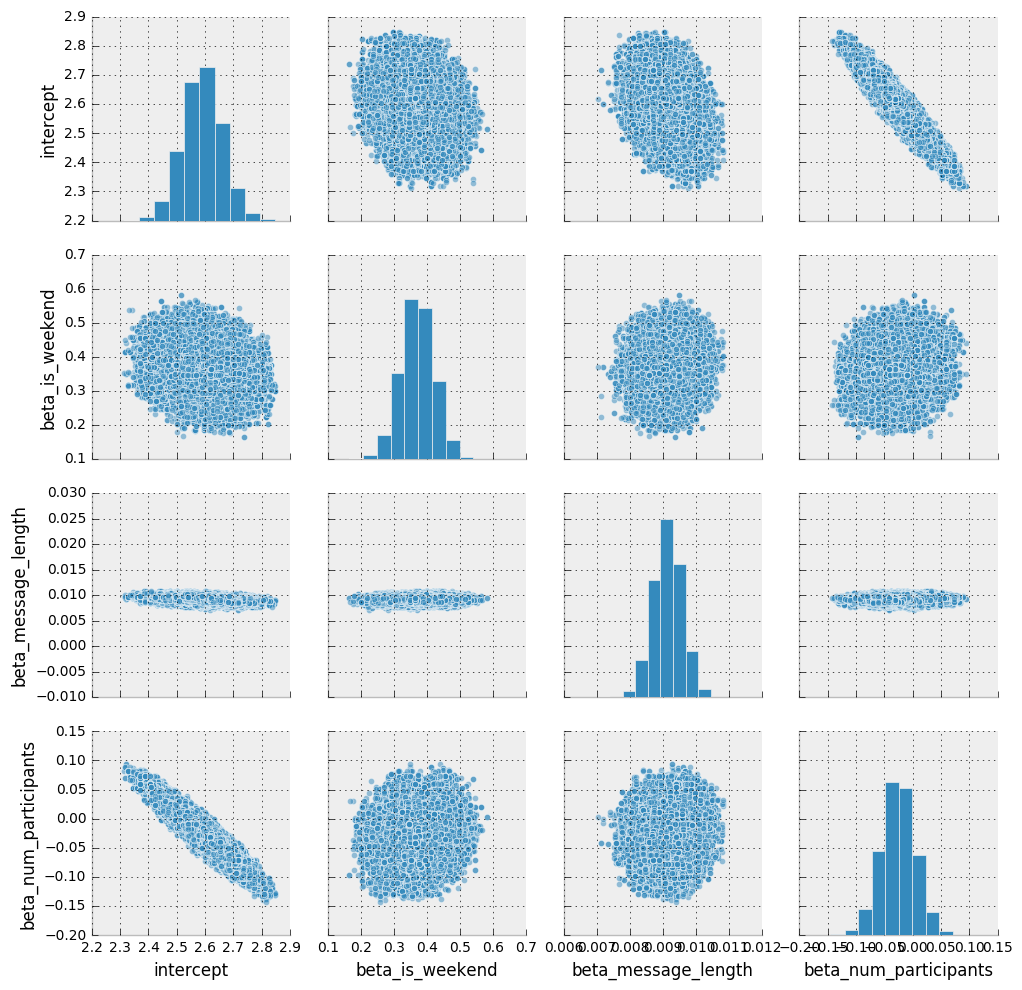

In [4]:
_ = sns.pairplot(pm.trace_to_dataframe(trace[20000:]), plot_kws={'alpha':.5})

### Mixed effects poisson regression

We can make a small extension to the above model by including a random intercept parameter. This will allow us to estimate a baseline parameter value $\beta_0$ for each person I communicate with. For all other parameters I will estimate a parameter across the entire population. For each person i and each message j, this is formally represented as:

$$y_{ji} \sim Poi(\mu)$$
$$\mu = \beta_{0_i} + \beta_1 x_1 ... \beta_n x_n$$

By introducing this random effects parameter $\beta_0$ for each person i, it allows the model to establish a different baseline for each person responded to - whilst estimating the  effects of the covariates on the response for the entire population.

In [5]:
# Convert categorical variables to integer
le = preprocessing.LabelEncoder()
participants_idx = le.fit_transform(messages['prev_sender'])
participants = le.classes_
n_participants = len(participants)

with pm.Model() as model:

    intercept = pm.Normal('intercept', mu=0, sd=100, shape=n_participants)
    slope_message_length = pm.Normal('slope_message_length', mu=0, sd=100)
    slope_is_weekend = pm.Normal('slope_is_weekend', mu=0, sd=100)
    slope_num_participants = pm.Normal('slope_num_participants', mu=0, sd=100)
    
    mu = tt.exp(intercept[participants_idx] 
                + slope_message_length*messages.message_length 
                + slope_is_weekend*messages.is_weekend
                + slope_num_participants*messages.num_participants)
    
    y_est = pm.Poisson('y_est', mu=mu, observed=messages['time_delay_seconds'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

100%|██████████| 200000/200000 [01:50<00:00, 1811.62it/s]


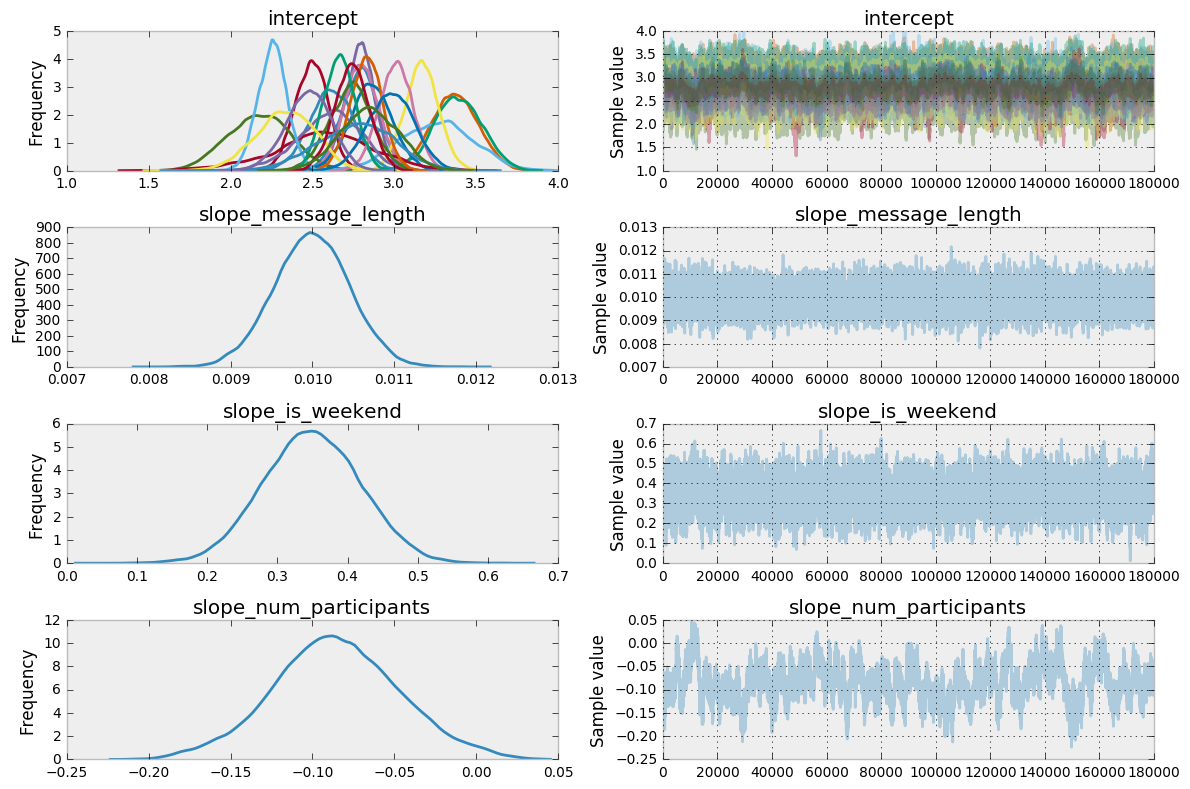

In [6]:
_ = pm.traceplot(trace[20000:])

The interpretation of the above results are interesting:
- Each person has a different baseline response rate (as shown in the pooled and partially pooled model in Section 3)
- Longer messages take longer to write and typically have longer response times
- You are more likely to get a slow response if you message me on the weekend
- I tend to reply more quickly to conversations that have multiple people added to it (group  chat)

And after accounting for the effect of each covariate on the response, the model estimates the below $\beta_0$ parameters.

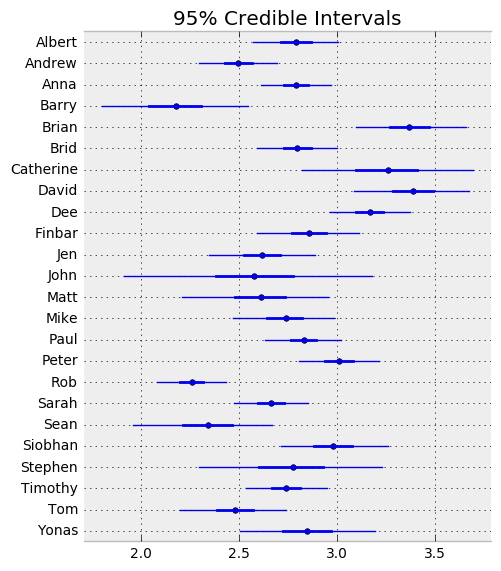

In [7]:
_ = plt.figure(figsize=(5, 6))
_ = pm.forestplot(trace[20000:], varnames=['intercept'], ylabels=participants)

### References

1. [How to interpret parameters of a poisson GLM](http://stats.stackexchange.com/questions/128926/how-to-interpret-parameter-estimates-in-poisson-glm-results)

In [8]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()